In [8]:
%matplotlib inline 

import gym
import numpy as np
import itertools
from collections import defaultdict

matplotlib.style.use('ggplot')

In [6]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

In [4]:
# ep-soft on-policy, first visit Monte Carlos control 

env = gym.make('Blackjack-v0')

ep = 0.1
num_iterations = 500000
num_actions = env.action_space.n

Q = defaultdict(lambda : np.zeros(num_actions, dtype=float))
all_returns = defaultdict(list)

def pi(state) :
    
    # policy improvement -- episolon greedy based on Q values
    greedy_action = np.argmax(Q[state])
    
    dist = np.ones(num_actions, dtype=float) * ep/num_actions
    dist[greedy_action] += 1 - ep
        
    return np.random.choice(num_actions, p=dist)

for ix in range(num_iterations) :
 
    # policy evaluation -- generate an episode
    
    first_visit_R = {}    # holds reward accumulated since the first visit to the state in this episode 
    
    S_t = env.reset()
    A_t = pi(S_t)
    S_tp1, R_tp1, done, info = env.step(A_t)
    first_visit_R[(S_t, A_t)] = R_tp1

    S_t = S_tp1
    
    while not done :
        A_t = pi(S_t)
        S_tp1, R_tp1, done, info = env.step(A_t)

        if S_t not in first_visit_R :
            first_visit_R[(S_t, A_t)] = 0

        first_visit_R = {state_action:returns+R_tp1 for state_action,returns in first_visit_R.iteritems()}
        
        S_t = S_tp1

    # policy evaluation -- update Q 
    
    for state_action, returns in first_visit_R.iteritems() :
        all_returns[state_action].append(returns)
        Q[state_action[0]][state_action[1]] = np.mean(all_returns[state_action])

[2017-05-26 12:44:09,216] Making new env: Blackjack-v0


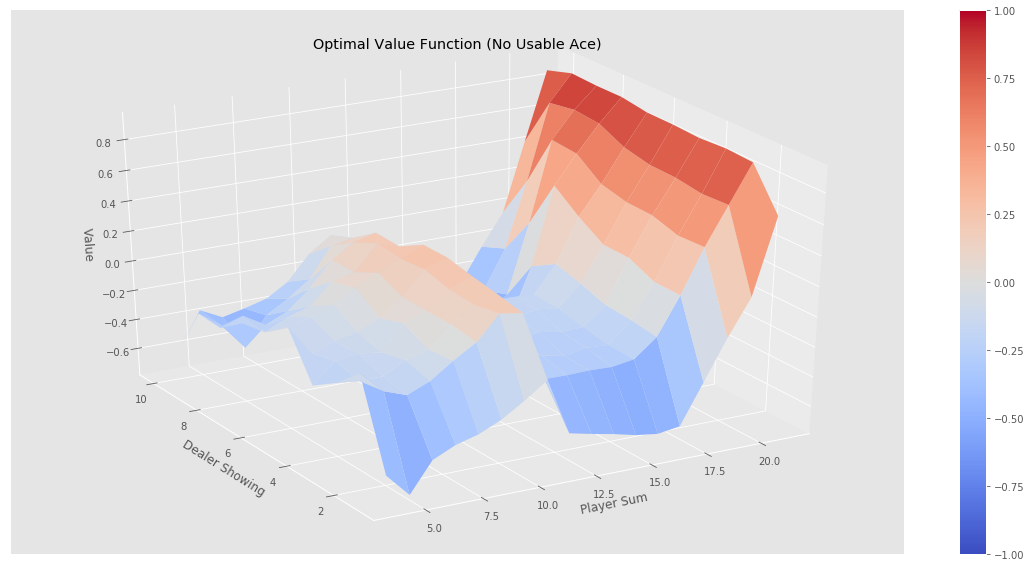

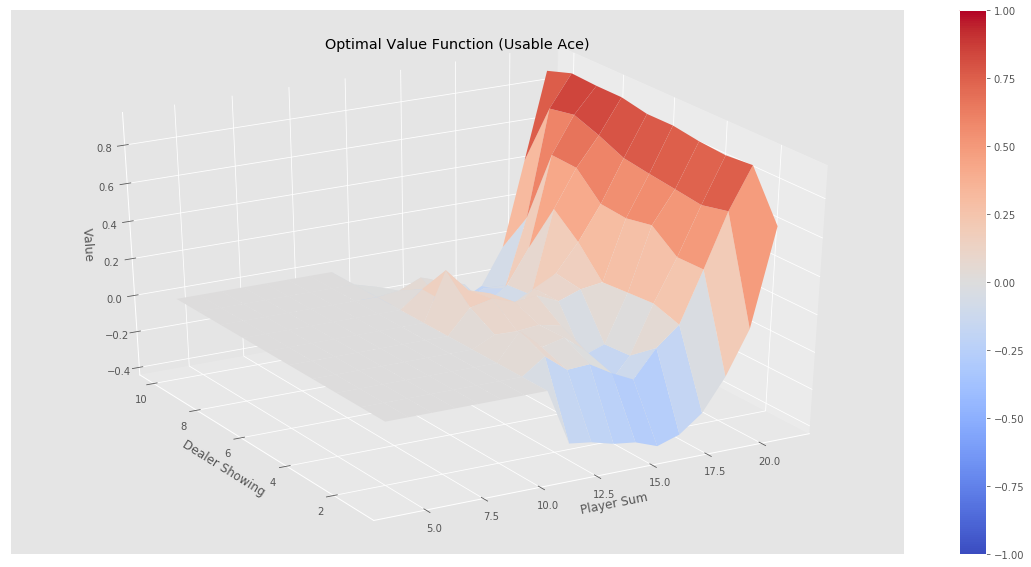

In [16]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function")